# ETH Daily Analysis - Data Processing Pipeline

This notebook processes raw Ethereum block data and market data to create a daily regression dataset for centrality analysis.

In [41]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## 1. Download ETH Market Data from Yahoo Finance

Download daily ETH price data and calculate returns.

In [42]:
yf_eth_data = yf.download("ETH-USD", start="2018-12-31", end="2025-07-23", interval="1d")
yf_eth_data.to_csv("../data/raw/ETH_daily_yf_data.csv")
print("Raw data saved ../data/raw/ETH_daily_yf_data.csv")


# Calculate daily returns (percentage change)
yf_eth_data["Daily Return"] = yf_eth_data["Close"].pct_change()
yf_eth_data = yf_eth_data.dropna()

print("First few daily returns:")
print(yf_eth_data.head())
print(f"\nReturns data shape: {yf_eth_data.shape}")
print(f"Date range: {yf_eth_data.index.min()} to {yf_eth_data.index.max()}")

/var/folders/l3/m0hmzwtx6x78f3q7cv6fpfl00000gn/T/ipykernel_42351/1703206388.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf_eth_data = yf.download("ETH-USD", start="2018-12-31", end="2025-07-23", interval="1d")
[*********************100%***********************]  1 of 1 completed

Raw data saved ../data/raw/ETH_daily_yf_data.csv
First few daily returns:
Price            Close        High         Low        Open      Volume  \
Ticker         ETH-USD     ETH-USD     ETH-USD     ETH-USD     ETH-USD   
Date                                                                     
2019-01-01  140.819412  141.397507  132.650711  133.418152  2258709868   
2019-01-02  155.047684  156.929138  140.650955  141.519516  3328240369   
2019-01-03  149.135010  155.863052  147.198364  155.196045  2676164880   
2019-01-04  154.581940  156.878983  147.907104  148.912888  3126192535   
2019-01-05  155.638596  160.824890  154.337418  154.337418  3338211928   

Price      Daily Return  
Ticker                   
Date                     
2019-01-01     0.055869  
2019-01-02     0.101039  
2019-01-03    -0.038135  
2019-01-04     0.036523  
2019-01-05     0.006836  

Returns data shape: (2395, 6)
Date range: 2019-01-01 00:00:00 to 2025-07-22 00:00:00


In [43]:
# Estimate daily volatilities

# 1. Garman-Klass method (CORRECT - from your image)
# Uses: 0.5 * ln(H/L)² - (2*ln(2) - 1) * ln(C/O)²
yf_eth_data['yf_garman_klass_vol'] = np.sqrt(
    0.5 * (np.log(yf_eth_data['High'] / yf_eth_data['Low']))**2 - 
    (2 * np.log(2) - 1) * (np.log(yf_eth_data['Close'] / yf_eth_data['Open']))**2
)

# 2. Yang-Zhang method (most comprehensive, handles drift and opening gaps)
k = 0.34 / (1.34 + (len(yf_eth_data) + 1) / (len(yf_eth_data) - 1))

overnight = np.log(yf_eth_data['Open'] / yf_eth_data['Close'].shift(1))
open_to_close = np.log(yf_eth_data['Close'] / yf_eth_data['Open'])

rs = (np.log(yf_eth_data['High'] / yf_eth_data['Close']) * np.log(yf_eth_data['High'] / yf_eth_data['Open']) + 
      np.log(yf_eth_data['Low'] / yf_eth_data['Close']) * np.log(yf_eth_data['Low'] / yf_eth_data['Open']))

yf_eth_data['yf_yang_zhang_vol'] = np.sqrt(overnight**2 + k * open_to_close**2 + (1 - k) * rs)

print("\nFirst few volatility measurements:")
print(yf_eth_data[['yf_garman_klass_vol', 'yf_yang_zhang_vol']].head(10))

# Summary statistics
print("\nVolatility Summary Statistics:")
print(yf_eth_data[['yf_garman_klass_vol', 'yf_yang_zhang_vol']].describe())


First few volatility measurements:
Price      yf_garman_klass_vol yf_yang_zhang_vol
Ticker                                          
Date                                            
2019-01-01            0.030212               NaN
2019-01-02            0.052696          0.053043
2019-01-03            0.031979          0.031373
2019-01-04            0.034566          0.033432
2019-01-05            0.028644          0.034153
2019-01-06            0.032179          0.031244
2019-01-07            0.022580          0.022605
2019-01-08            0.022226          0.020758
2019-01-09            0.015481          0.018071
2019-01-10            0.084796          0.085979

Volatility Summary Statistics:
Price  yf_garman_klass_vol yf_yang_zhang_vol
Ticker                                      
count          2395.000000       2394.000000
mean              0.033029          0.033177
std               0.023513          0.024226
min               0.002442          0.002368
25%               0.01874

## 2. Calculate Volatility Measures

Calculate Garman-Klass and Yang-Zhang volatility estimators using OHLC data.

Notice that there are days with Garman Klass Vol = 0
This likely happens because yf populated data with Open = Low, resulting in the log term being 0. Delete rows later.

In [44]:
zero_vol_days = yf_eth_data[yf_eth_data['yf_garman_klass_vol'] == 0]
print("Days with zero Garman-Klass volatility:")
print(zero_vol_days[['Open', 'High', 'Low', 'Close', 'yf_garman_klass_vol']])

Days with zero Garman-Klass volatility:
Empty DataFrame
Columns: [(Open, ETH-USD), (High, ETH-USD), (Low, ETH-USD), (Close, ETH-USD), (yf_garman_klass_vol, )]
Index: []


## 3. Load Professor's Data

Load market data and Ethereum data from Excel files.

In [45]:
prof_eth_data = pd.read_excel("../data/raw/ethereum.xlsx")
prof_market_data = pd.read_excel("../data/raw/crypto_market.xlsx")

print("First few rows of prof_eth_data:")
print(prof_eth_data.head())
print(f"\nprof_eth_data shape: {prof_eth_data.shape}")
print(f"Date range: {prof_eth_data['date'].min()} to {prof_eth_data['date'].max()}")        

print("\nFirst few rows of prof_market_data:")  
print(prof_market_data.head())
print(f"\nprof_market_data shape: {prof_market_data.shape}")
print(f"Date range: {prof_market_data['date'].min()} to {prof_market_data['date'].max()}")

First few rows of prof_eth_data:
        date  marketcap_million    return  volume_million  intraday_vol  \
0 2019-01-01       14677.921718  0.060834     1826.652360      0.110659   
1 2019-01-02       16178.084281  0.100070     2487.766985      0.056184   
2 2019-01-03       15537.033905 -0.044607     2328.806403      0.022059   
3 2019-01-04       16107.068093  0.037644     2503.604200      0.045937   
4 2019-01-05       16219.974745  0.008584     2777.280251      0.056285   

         open        high         low       close  
0  133.418145  142.355045  132.695779  141.534501  
1  141.900000  157.603889  141.202228  156.100000  
2  156.100000  156.100000  147.176105  149.136769  
3  149.440000  157.625844  147.907099  155.065516  
4  154.890350  160.854178  154.600000  156.220000  

prof_eth_data shape: (2404, 9)
Date range: 2019-01-01 00:00:00 to 2025-07-31 00:00:00

First few rows of prof_market_data:
        date    return  volume_million  marketcap_million  volatility
0 2019-01-

In [46]:
# Estimate daily volatilities

# 1. Garman-Klass method (CORRECT - from your image)
# Uses: 0.5 * ln(H/L)² - (2*ln(2) - 1) * ln(C/O)²
prof_eth_data['prof_garman_klass_vol'] = np.sqrt(
    0.5 * (np.log(prof_eth_data['high'] / prof_eth_data['low']))**2 - 
    (2 * np.log(2) - 1) * (np.log(prof_eth_data['close'] / prof_eth_data['open']))**2
)

# 2. Yang-Zhang method (most comprehensive, handles drift and opening gaps)
k = 0.34 / (1.34 + (len(prof_eth_data) + 1) / (len(prof_eth_data) - 1))

overnight = np.log(prof_eth_data['open'] / prof_eth_data['close'].shift(1))
open_to_close = np.log(prof_eth_data['close'] / prof_eth_data['open'])

rs = (np.log(prof_eth_data['high'] / prof_eth_data['close']) * np.log(prof_eth_data['high'] / prof_eth_data['open']) + 
      np.log(prof_eth_data['low'] / prof_eth_data['close']) * np.log(prof_eth_data['low'] / prof_eth_data['open']))

prof_eth_data['prof_yang_zhang_vol'] = np.sqrt(overnight**2 + k * open_to_close**2 + (1 - k) * rs)

print("\nFirst few volatility measurements:")
print(prof_eth_data[['prof_garman_klass_vol', 'prof_yang_zhang_vol']].head(10))

# Summary statistics
print("\nVolatility Summary Statistics:")
print(prof_eth_data[['prof_garman_klass_vol', 'prof_yang_zhang_vol']].describe())


First few volatility measurements:
   prof_garman_klass_vol  prof_yang_zhang_vol
0               0.033487                  NaN
1               0.050242             0.051095
2               0.030467             0.031118
3               0.038698             0.036952
4               0.027534             0.031187
5               0.033261             0.032429
6               0.022580             0.022605
7               0.022226             0.020758
8               0.015481             0.018071
9               0.093617             0.094030

Volatility Summary Statistics:
       prof_garman_klass_vol  prof_yang_zhang_vol
count            2404.000000          2403.000000
mean                0.032840             0.032938
std                 0.023182             0.023821
min                 0.002511             0.002393
25%                 0.018727             0.018641
50%                 0.027327             0.027346
75%                 0.039670             0.039734
max                 0.3476

## 4. Preprocess Block Data

**Prerequisites**: This section requires `ETH_Block_Data_Cleaned.csv` to exist in `../data/raw/`.

**Note**: The heavy data cleaning (combining multiple CSV files from ETH Block Data folder, removing 400k+ duplicate rows) is performed in `ETH_analysis.ipynb`. That notebook must be run first. This section only performs:
- Final duplicate removal (safety check)
- Date extraction from DateTime
- Block number validation
- Column reordering


In [47]:
# yf_eth_data = yf_eth_data.reset_index()
yf_eth_data.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in yf_eth_data.columns.values]
print(yf_eth_data.columns)

print(prof_eth_data.columns)

print(prof_market_data.columns)

Index(['Close_ETH-USD', 'High_ETH-USD', 'Low_ETH-USD', 'Open_ETH-USD',
       'Volume_ETH-USD', 'Daily Return', 'yf_garman_klass_vol',
       'yf_yang_zhang_vol'],
      dtype='object')
Index(['date', 'marketcap_million', 'return', 'volume_million', 'intraday_vol',
       'open', 'high', 'low', 'close', 'prof_garman_klass_vol',
       'prof_yang_zhang_vol'],
      dtype='object')
Index(['date', 'return', 'volume_million', 'marketcap_million', 'volatility'], dtype='object')


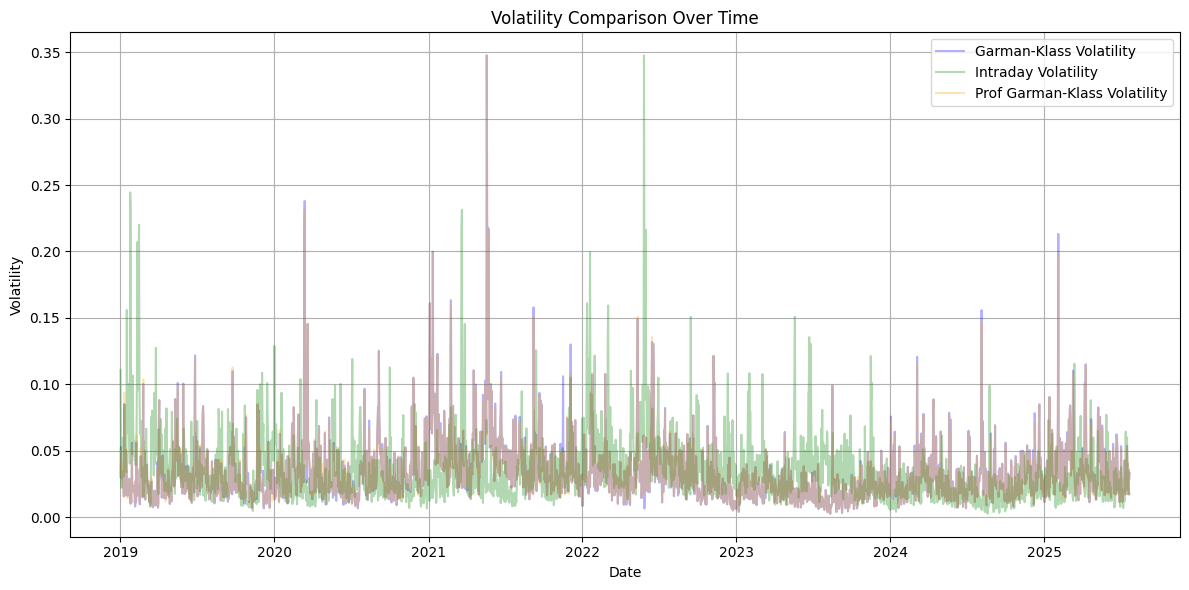

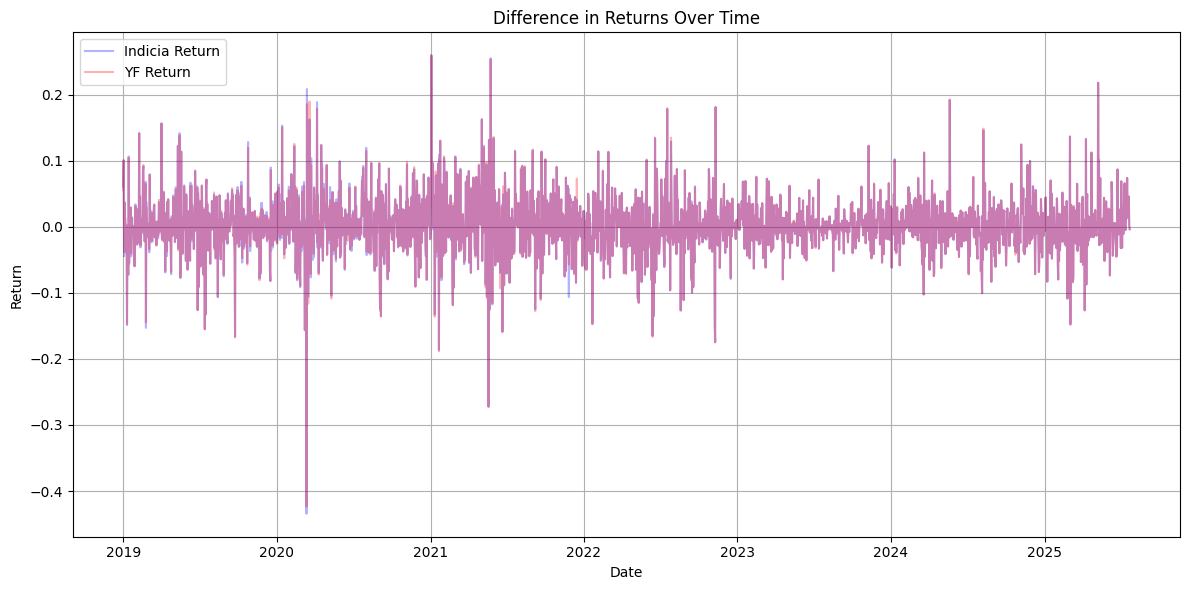

In [48]:
# Join all three df on date
prof_eth_data['date'] = pd.to_datetime(prof_eth_data['date']).dt.normalize()
prof_market_data['date'] = pd.to_datetime(prof_market_data['date']).dt.normalize()
yf_eth_data = yf_eth_data.reset_index()
yf_eth_data['Date'] = pd.to_datetime(yf_eth_data['Date']).dt.normalize()

# Rename columns to avoid conflicts
prof_eth_data_renamed = prof_eth_data.rename(columns={
    'return': 'eth_return',
    'volume_million': 'eth_volume_million',
    'marketcap_million': 'eth_marketcap_million',
    'intraday_vol': 'eth_intraday_vol',
    'prof_garman_klass_vol': 'prof_garman_klass_vol',
    'prof_yang_zhang_vol': 'prof_yang_zhang_vol'
})

prof_market_data_renamed = prof_market_data.rename(columns={
    'return': 'market_return',
    'volume_million': 'market_volume_million',
    'marketcap_million': 'market_marketcap_million',
    'volatility': 'market_volatility'
})

# Perform merges
df = pd.merge(prof_eth_data_renamed, prof_market_data_renamed, on='date', how='inner')
df = pd.merge(
    df, 
    yf_eth_data[['Date', 'Daily Return', 'yf_garman_klass_vol', 'yf_yang_zhang_vol']], 
    left_on='date', 
    right_on='Date', 
    how='inner'
)
df.drop(columns=['Date'], inplace=True)

# Plot the graphs to visualize the relationships
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['yf_garman_klass_vol'], label='Garman-Klass Volatility', color='blue', alpha=0.3)
plt.plot(df['date'], df['eth_intraday_vol'], label='Intraday Volatility', color='green', alpha=0.3)
plt.plot(df['date'], df['prof_garman_klass_vol'], label='Prof Garman-Klass Volatility', color='orange', alpha=0.3)
plt.title('Volatility Comparison Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot the returns to visualize the difference between YF and Indicia data
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['eth_return'], label='Indicia Return', color='blue', alpha=0.3)
plt.plot(df['date'], df['Daily Return'], label='YF Return', color='red', alpha=0.3)
plt.title('Difference in Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [49]:
df.columns

Index(['date', 'eth_marketcap_million', 'eth_return', 'eth_volume_million',
       'eth_intraday_vol', 'open', 'high', 'low', 'close',
       'prof_garman_klass_vol', 'prof_yang_zhang_vol', 'market_return',
       'market_volume_million', 'market_marketcap_million',
       'market_volatility', 'Daily Return', 'yf_garman_klass_vol',
       'yf_yang_zhang_vol'],
      dtype='object')

In [50]:
# process and save final block data

def preprocess_eth_blocks_csv(input_file, output_file):
    """
    Preprocess ETH blocks CSV:
    1. Remove duplicates based on Block number
    2. Extract Date from DateTime (UTC) 
    3. Clean and validate data
    4. Save to new file
    """
    
    print(f"Loading CSV file: {input_file}")
    
    try:
        # Load CSV with pandas
        df = pd.read_csv(input_file)
        print(f"✅ Loaded {len(df)} rows")
        
        # Show original columns
        print(f"Original columns: {list(df.columns)}")
        
        # Check for DateTime (UTC) column
        if 'DateTime (UTC)' not in df.columns:
            print("❌ 'DateTime (UTC)' column not found!")
            return False
            
        # Check for Block column
        if 'Block' not in df.columns:
            print("❌ 'Block' column not found!")
            return False
        
        print(f"Date range: {df['DateTime (UTC)'].min()} to {df['DateTime (UTC)'].max()}")
        
        # Remove duplicates based on Block number (primary key)
        initial_count = len(df)
        df = df.drop_duplicates(subset=['Block'], keep='first')
        duplicates_removed = initial_count - len(df)
        print(f"✅ Removed {duplicates_removed} duplicate blocks")
        
        # Extract Date from DateTime (UTC)
        print("Extracting dates from DateTime (UTC)...")
        df['Date'] = pd.to_datetime(df['DateTime (UTC)']).dt.strftime('%Y-%m-%d')
        
        # Validate dates were extracted correctly
        print(f"✅ Date extraction complete. Unique dates: {df['Date'].nunique()}")
        print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
        
        # Clean numeric columns (remove commas)
        numeric_columns = ['Block', 'Slot', 'Epoch', 'Txn', 'Gas Used', 'Gas Limit']
        for col in numeric_columns:
            if col in df.columns:
                df[col] = df[col].astype(str).str.replace(',', '')
        
        # Remove rows with invalid Block numbers
        initial_count = len(df)
        df = df[pd.to_numeric(df['Block'], errors='coerce').notna()]
        invalid_blocks = initial_count - len(df)
        if invalid_blocks > 0:
            print(f"⚠️  Removed {invalid_blocks} rows with invalid block numbers")
        
        # Reorder columns to put keys first
        cols = df.columns.tolist()
        # Move Date and Block to front
        if 'Date' in cols:
            cols.remove('Date')
        if 'Block' in cols:
            cols.remove('Block')
        df = df[['Date', 'Block'] + cols]
        
        # Save processed file
        df.to_csv(output_file, index=False)
        print(f"✅ Processed file saved: {output_file}")
        print(f"Final record count: {len(df)}")
        
        # Show sample of processed data
        print("\nSample of processed data:")
        print(df[['Date', 'Block', 'DateTime (UTC)', 'Fee Recipient']].head())
        
        return True
        
    except Exception as e:
        print(f"❌ Error processing file: {str(e)}")
        return False

def validate_processed_file(file_path):
    """Validate the processed file for common issues"""
    try:
        df = pd.read_csv(file_path)
        
        print(f"\n=== Validation Results ===")
        print(f"Total records: {len(df)}")
        print(f"Unique blocks: {df['Block'].nunique()}")
        print(f"Unique dates: {df['Date'].nunique()}")
        
        # Check for missing required fields
        missing_dates = df['Date'].isna().sum()
        missing_blocks = df['Block'].isna().sum()
        
        if missing_dates > 0:
            print(f"⚠️  {missing_dates} rows missing Date")
        if missing_blocks > 0:
            print(f"⚠️  {missing_blocks} rows missing Block")
            
        # Check date format
        try:
            pd.to_datetime(df['Date'].dropna())
            print(f"✅ All dates are valid format")
        except:
            print(f"❌ Some dates have invalid format")
            
        # Show data distribution
        print(f"\nRecords per date (top 10):")
        print(df['Date'].value_counts().head(10))
        
        return True
        
    except Exception as e:
        print(f"❌ Validation error: {str(e)}")
        return False

if __name__ == "__main__":
    input_file = "../data/raw/ETH_Block_Data_Cleaned.csv"
    output_file = "../data/raw/ETH_Block_Data_Processed.csv"
    
    print("=== ETH Blocks CSV Preprocessing ===")
    
    # Check if input file exists
    if not os.path.exists(input_file):
        print(f"❌ Input file not found: {input_file}")
        # File not found - check path
    
    # Preprocess the file
    if preprocess_eth_blocks_csv(input_file, output_file):
        print(f"\n=== Preprocessing completed successfully! ===")
        
        # Validate the processed file
        validate_processed_file(output_file)
        
        print(f"\n🎉 Ready for DynamoDB upload: {output_file}")
    else:
        print(f"❌ Preprocessing failed")

=== ETH Blocks CSV Preprocessing ===
Loading CSV file: ../data/raw/ETH_Block_Data_Cleaned.csv
✅ Loaded 11928602 rows
Original columns: ['Block', 'Slot', 'Epoch', 'DateTime (UTC)', 'BlobCount', 'Txn', 'Fee Recipient', 'Fee Recipient Nametag', 'Gas Used', 'Gas Used(%)', ' % Of Gas Target', 'Gas Limit', 'Base Fee', 'Reward', 'Burnt Fees (ETH)', 'Burnt Fees (%)', 'source_file', 'observation_date', 'DFF']
Date range: 2020-07-12 00:08:28 to 2025-09-22 19:00:11
✅ Removed 0 duplicate blocks
Extracting dates from DateTime (UTC)...
✅ Date extraction complete. Unique dates: 1841
Date range: 2020-07-12 to 2025-09-22
✅ Processed file saved: ../data/raw/ETH_Block_Data_Processed.csv
Final record count: 11928602

Sample of processed data:
         Date     Block       DateTime (UTC)  \
0  2020-07-12  10441379  2020-07-12 00:08:28   
1  2020-07-12  10441380  2020-07-12 00:08:48   
2  2020-07-12  10441381  2020-07-12 00:09:15   
3  2020-07-12  10441382  2020-07-12 00:09:16   
4  2020-07-12  10441383  20

## 5. Load Processed Block Data

Load the preprocessed block data for centrality calculations.

In [51]:
block_data = pd.read_csv("../data/raw/ETH_Block_Data_Processed.csv")
print(f"block_data columns: {block_data.columns.tolist()}")
print(f"\nblock_data shape: {block_data.shape}")
print(f"Date range: {block_data['Date'].min()} to {block_data['Date'].max()}")

block_data columns: ['Date', 'Block', 'Slot', 'Epoch', 'DateTime (UTC)', 'BlobCount', 'Txn', 'Fee Recipient', 'Fee Recipient Nametag', 'Gas Used', 'Gas Used(%)', ' % Of Gas Target', 'Gas Limit', 'Base Fee', 'Reward', 'Burnt Fees (ETH)', 'Burnt Fees (%)', 'source_file', 'observation_date', 'DFF']

block_data shape: (11928602, 20)
Date range: 2020-07-12 to 2025-09-22


In [52]:
"""
Identify missing blocks in the sequence
"""
print("="*50)
print("FINDING MISSING BLOCKS")
print("="*50)

# Sort by block number
blocks_sorted = block_data.sort_values('Block').reset_index(drop=True)

min_block = blocks_sorted['Block'].min()
max_block = blocks_sorted['Block'].max()

print(f"Block range: {min_block:,} to {max_block:,}")
print(f"Total blocks in range: {max_block - min_block + 1:,}")
print(f"Blocks we have: {len(blocks_sorted):,}")

# Create complete sequence of blocks
complete_sequence = set(range(min_block, max_block + 1))
actual_blocks = set(blocks_sorted['Block'])

# Find missing blocks
missing_blocks = sorted(list(complete_sequence - actual_blocks))

print(f"Missing blocks: {len(missing_blocks):,}")

if missing_blocks:
    print(f"\nFirst 20 missing blocks: {missing_blocks[:20]}")
    if len(missing_blocks) > 20:
        print(f"Last 20 missing blocks: {missing_blocks[-20:]}")
    
    # Analyze missing block patterns
    if len(missing_blocks) > 1:
        gaps = []
        current_gap_start = missing_blocks[0]
        current_gap_end = missing_blocks[0]
        
        for i in range(1, len(missing_blocks)):
            if missing_blocks[i] == missing_blocks[i-1] + 1:
                # Consecutive missing block
                current_gap_end = missing_blocks[i]
            else:
                # Gap ended, record it
                if current_gap_start == current_gap_end:
                    gaps.append(f"Block {current_gap_start}")
                else:
                    gaps.append(f"Blocks {current_gap_start}-{current_gap_end}")
                
                current_gap_start = missing_blocks[i]
                current_gap_end = missing_blocks[i]
        
        # Don't forget the last gap
        if current_gap_start == current_gap_end:
            gaps.append(f"Block {current_gap_start}")
        else:
            gaps.append(f"Blocks {current_gap_start}-{current_gap_end}")
        
        print(f"\nMissing block gaps ({len(gaps)} gaps):")
        for gap in gaps[:10]:  # Show first 10 gaps
            print(f"  - {gap}")
        if len(gaps) > 10:
            print(f"  ... and {len(gaps) - 10} more gaps")

# Calculate coverage percentage
coverage = (len(actual_blocks) / len(complete_sequence)) * 100
print(f"\nData coverage: {coverage:.2f}%")

FINDING MISSING BLOCKS
Block range: 10,441,379 to 23,420,514
Total blocks in range: 12,979,136
Blocks we have: 11,928,602
Missing blocks: 1,050,534

First 20 missing blocks: [10449369, 10449370, 10449371, 10449372, 10449373, 10449374, 10449375, 10449376, 10449377, 10449378, 10449379, 10449380, 10449381, 10449382, 10449383, 10449384, 10449385, 10449386, 10449387, 10449388]
Last 20 missing blocks: [23419998, 23419999, 23420000, 23420001, 23420002, 23420003, 23420004, 23420005, 23420006, 23420007, 23420008, 23420009, 23420010, 23420011, 23420012, 23420013, 23420014, 23420015, 23420016, 23420017]

Missing block gaps (5114 gaps):
  - Blocks 10449369-10449467
  - Block 10561117
  - Block 10651692
  - Blocks 10694636-10694735
  - Blocks 10710415-10710514
  - Blocks 10896469-10896568
  - Blocks 10980762-10980861
  - Blocks 11083527-11083625
  - Blocks 11184491-11184590
  - Blocks 11275572-11275671
  ... and 5104 more gaps

Data coverage: 91.91%


## 6. Calculate Centrality Metrics

Calculate validator centralization metrics: Top-N centrality, HHI, and Gini coefficient.

In [53]:
"""
Analyze the distribution of block miners
"""
print("\n" + "="*50)
print("MINER ANALYSIS")
print("="*50)

# Count blocks by miner
miner_counts = blocks_sorted['Fee Recipient Nametag'].value_counts()

print("Top 20 MINERS:")
print(miner_counts.head(20))

# Calculate percentage for top miners
total_blocks = len(blocks_sorted)
top_20_miners = miner_counts.head(20)
top_20_percentage = (top_20_miners.sum() / total_blocks) * 100

print(f"\nTop 20 miners mined {top_20_percentage:.2f}% of all blocks")

# Create a summary dataframe for later analysis
miner_summary = pd.DataFrame({
    'miner': miner_counts.index,
    'blocks_mined': miner_counts.values,
    'percentage': (miner_counts.values / total_blocks) * 100
}).reset_index(drop=True)


MINER ANALYSIS
Top 20 MINERS:
Fee Recipient Nametag
beaverbuild                            2048941
Titan Builder                          1410470
Ethermine                              1241190
rsync-builder.eth                       690218
Spark Pool                              680346
F2Pool Old                              617330
Flashbots: Builder                      479585
builder0x69                             380993
Lido: Execution Layer Rewards Vault     349071
Hiveon Pool                             328836
Nanopool                                205096
2Miners: PPLNS                          177079
zhizhu.top                              170926
Flexpool.io                             126945
BuilderNet                              122272
MiningPoolHub                           118565
BeePool                                 102797
Coinbase: MEV Builder                   100997
Babel Pool                               87383
UUPool                                   82611
Name: c

In [54]:
# # Debug the datetime conversion issue

# # 1. Check the data type of the DateTime column
# print("Current dtype of DateTime column:", df['DateTime (UTC)'].dtype)

# # 2. Look at some sample values
# print("\nSample DateTime values:")
# print(df['DateTime (UTC)'].head(10))

# # 3. Check for null/NaN values
# print(f"\nNull values in DateTime column: {df['DateTime (UTC)'].isnull().sum()}")

# # 4. Check for non-string values
# print(f"Data types in DateTime column:")
# print(df['DateTime (UTC)'].apply(type).value_counts())

In [55]:
print("\n" + "="*50)
print("DAILY MINER ANALYSIS")
print("="*50)

blocks_sorted['DateTime (UTC)'] = pd.to_datetime(blocks_sorted['DateTime (UTC)'])

# Create a day identifier for grouping
blocks_sorted['date'] = blocks_sorted['DateTime (UTC)'].dt.normalize()

# Get all unique days
unique_days = sorted(blocks_sorted['date'].unique())
print(f"Total days of data: {len(unique_days)}")
print(f"Date range: {unique_days[0].date()} to {unique_days[-1].date()}")

# Initialize list to store daily data
daily_data = []
missing_days = []

# Process each day
for day in unique_days:
    # Get blocks for this day
    day_blocks = blocks_sorted[blocks_sorted['date'] == day]
    
    if len(day_blocks) == 0:
        missing_days.append(day)
        continue
    
    # Count blocks by miner for this day
    day_miner_counts = day_blocks['Fee Recipient Nametag'].value_counts()
    
    # Calculate percentages
    total_day_blocks = len(day_blocks)
    day_percentages = (day_miner_counts / total_day_blocks) * 100
    
    # Get top 20 miners for this day (pad with zeros if less than 20)
    top_20_day = day_percentages.head(20)
    
    # Create array of 20 values (pad with 0 if needed)
    day_array = []
    for i in range(20):
        if i < len(top_20_day):
            day_array.append(top_20_day.iloc[i])
        else:
            day_array.append(0.0)
    
    daily_data.append(day_array)

print(f"Completed processing {len(daily_data)} days")

# Create DataFrame directly
columns = [f'miner_rank_{i+1}' for i in range(20)]
daily_miners_df = pd.DataFrame(daily_data, columns=columns)
daily_miners_df['date'] = unique_days[:len(daily_data)]

print(f"\nDaily miners DataFrame shape: {daily_miners_df.shape}")
print(f"Days with data: {len(daily_miners_df)}")

# Show first few rows
print("\nFirst 5 days (showing top 5 miners only):")
print(daily_miners_df[['date', 'miner_rank_1', 'miner_rank_2', 'miner_rank_3', 'miner_rank_4', 'miner_rank_5']].head())


DAILY MINER ANALYSIS
Total days of data: 1841
Date range: 2020-07-12 to 2025-09-22
Completed processing 1841 days

Daily miners DataFrame shape: (1841, 21)
Days with data: 1841

First 5 days (showing top 5 miners only):
        date  miner_rank_1  miner_rank_2  miner_rank_3  miner_rank_4  \
0 2020-07-12     28.403283     20.179650      8.997987      8.486913   
1 2020-07-13     29.371286     21.410698      8.461057      7.851110   
2 2020-07-14     28.754293     21.089603      8.788636      7.711520   
3 2020-07-15     30.425367     20.108275      8.739366      8.631090   
4 2020-07-16     29.560337     20.657936      8.497038      8.122856   

   miner_rank_5  
0      5.141707  
1      4.957773  
2      5.510459  
3      4.887858  
4      5.067041  


In [56]:
print("\n" + "="*50)
print("DAILY MINER STATISTICS")
print("="*50)

# Calculate mean and standard deviation for each rank
stats_data = []
for i in range(20):
    col_name = f'miner_rank_{i+1}'
    mean_val = daily_miners_df[col_name].mean()
    std_val = daily_miners_df[col_name].std()
    
    stats_data.append({
        'rank': i+1,
        'mean_percentage': mean_val,
        'std_percentage': std_val
    })

miner_stats_df = pd.DataFrame(stats_data)

print("Statistics for top 20 miner ranks:")
print(miner_stats_df.head(10))

# Print key statistics
print(f"\nKey Statistics:")
print(f"Top miner average: {miner_stats_df.iloc[0]['mean_percentage']:.2f}% ± {miner_stats_df.iloc[0]['std_percentage']:.2f}%")
print(f"2nd miner average: {miner_stats_df.iloc[1]['mean_percentage']:.2f}% ± {miner_stats_df.iloc[1]['std_percentage']:.2f}%")
print(f"3rd miner average: {miner_stats_df.iloc[2]['mean_percentage']:.2f}% ± {miner_stats_df.iloc[2]['std_percentage']:.2f}%")

# Calculate centralization metrics
top_3_mean = miner_stats_df.head(3)['mean_percentage'].sum()
top_5_mean = miner_stats_df.head(5)['mean_percentage'].sum()
top_10_mean = miner_stats_df.head(10)['mean_percentage'].sum()

print(f"\nCentralization Metrics (Daily averages):")
print(f"Top 3 miners control: {top_3_mean:.2f}% of blocks")
print(f"Top 5 miners control: {top_5_mean:.2f}% of blocks") 
print(f"Top 10 miners control: {top_10_mean:.2f}% of blocks")


DAILY MINER STATISTICS
Statistics for top 20 miner ranks:
   rank  mean_percentage  std_percentage
0     1        31.079110        9.707395
1     2        22.646319        7.945646
2     3        10.653073        3.806339
3     4         6.289568        2.569468
4     5         4.378989        2.133643
5     6         3.130880        1.531475
6     7         2.421875        1.291545
7     8         1.954558        1.132687
8     9         1.635132        1.006703
9    10         1.415521        0.926241

Key Statistics:
Top miner average: 31.08% ± 9.71%
2nd miner average: 22.65% ± 7.95%
3rd miner average: 10.65% ± 3.81%

Centralization Metrics (Daily averages):
Top 3 miners control: 64.38% of blocks
Top 5 miners control: 75.05% of blocks
Top 10 miners control: 85.61% of blocks



CREATING GROUPED HISTOGRAM


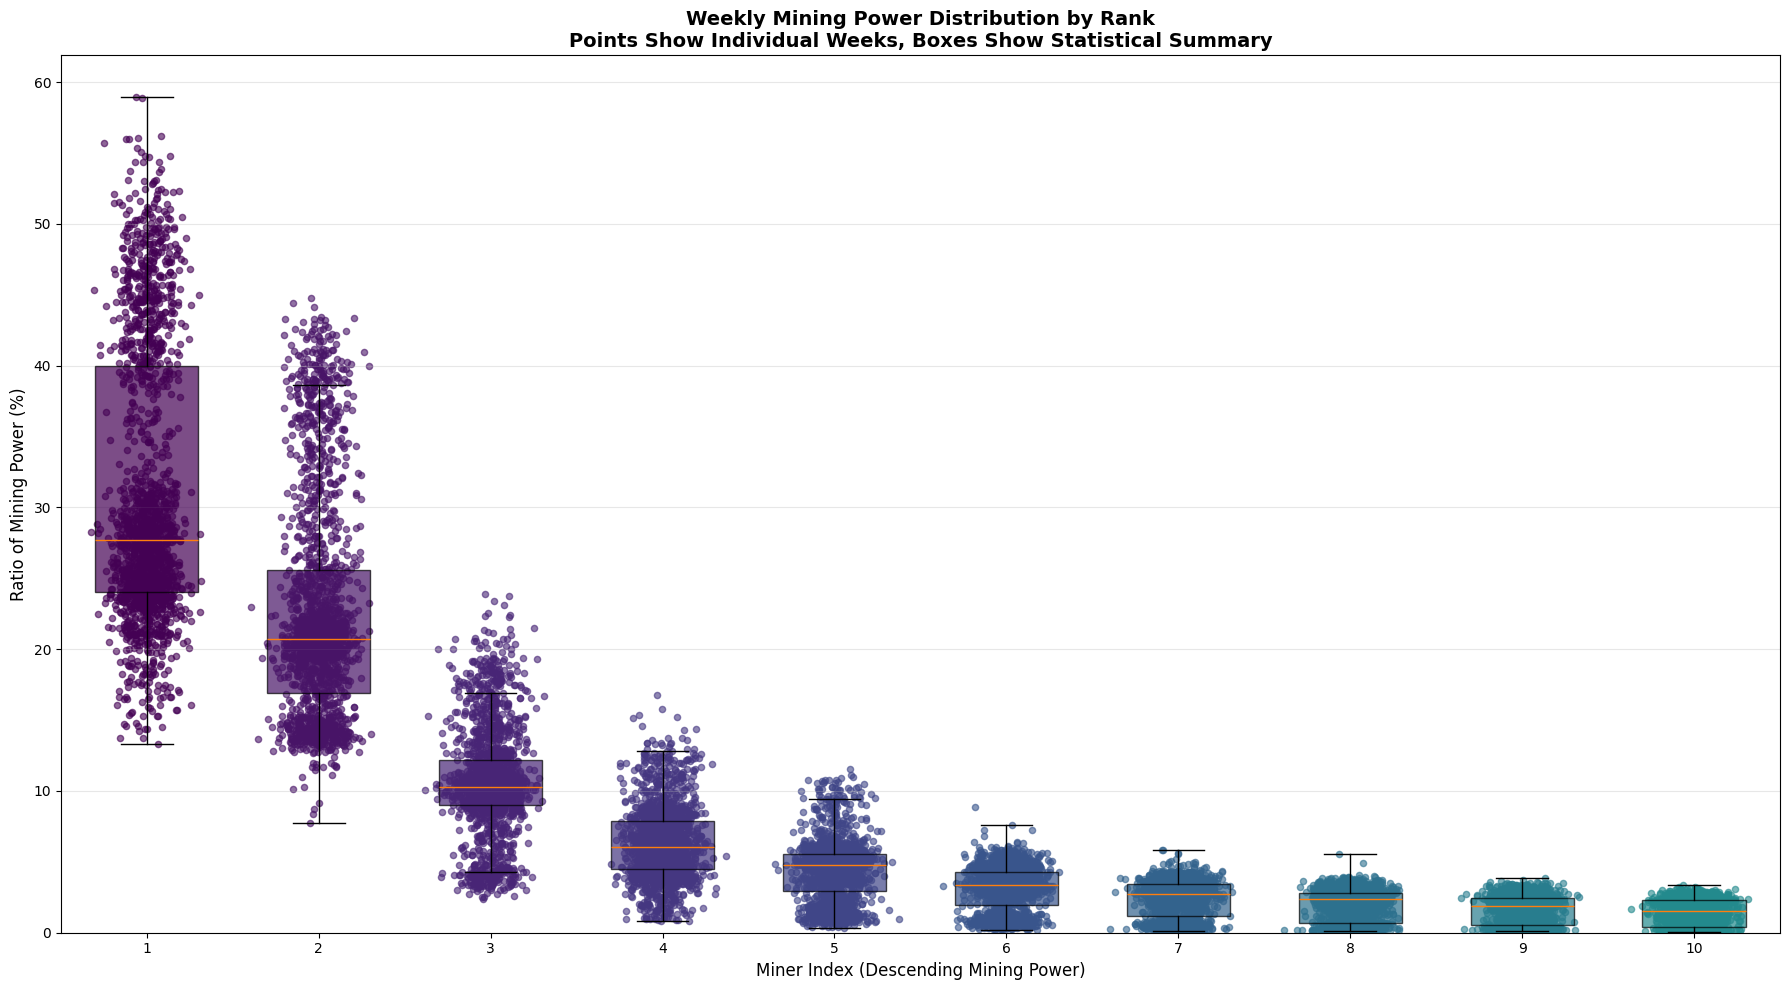

In [57]:
print("\n" + "="*50)
print("CREATING GROUPED HISTOGRAM")
print("="*50)

# Create the grouped histogram showing distribution for each miner rank

# Prepare data for all 20 miner ranks
miner_data = []
miner_positions = []

for i in range(20):
    col_name = f'miner_rank_{i+1}'
    data = daily_miners_df[col_name].values
    # Only include non-zero values to avoid cluttering
    data = data[data > 0]
    if len(data) > 0:
        miner_data.append(data)
        miner_positions.append(i+1)

colors = plt.cm.viridis(np.linspace(0, 1, len(miner_data)))


fig, ax = plt.subplots(figsize=(18, 10))

# Create a more detailed histogram for top 10 miners
n_miners = 10
width = 0.8
x_positions = np.arange(1, n_miners + 1)

# For each miner rank, create a histogram of their weekly percentages
for i in range(n_miners):
    col_name = f'miner_rank_{i+1}'
    data = daily_miners_df[col_name].values
    
    # Create bins for this miner's data
    if data.max() > 0:
        # Create small offset for each week's data point
        n_weeks = len(data)
        jitter = np.random.normal(0, 0.1, n_weeks)  # Small random offset
        x_pos = np.full(n_weeks, i+1) + jitter
        
        # Plot individual points
        ax.scatter(x_pos, data, alpha=0.6, s=20, color=colors[i] if i < len(colors) else 'gray')

# Overlay with box plots for clear statistics
box_data = [daily_miners_df[f'miner_rank_{i+1}'].values for i in range(n_miners)]
bp = ax.boxplot(box_data, positions=range(1, n_miners + 1), widths=0.6, 
                patch_artist=True, showfliers=False)

# Color the box plots
for i, patch in enumerate(bp['boxes']):
    patch.set_facecolor(colors[i] if i < len(colors) else 'lightgray')
    patch.set_alpha(0.7)

ax.set_xlabel('Miner Index (Descending Mining Power)', fontsize=12)
ax.set_ylabel('Ratio of Mining Power (%)', fontsize=12)
ax.set_title('Weekly Mining Power Distribution by Rank\nPoints Show Individual Weeks, Boxes Show Statistical Summary', fontsize=14, fontweight='bold')
ax.set_xticks(range(1, n_miners + 1))
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

In [58]:
print("\n" + "="*60)
print("CREATING CENTRALITY METRICS")
print("="*60)

# Calculate centralization metrics for each day using mean and std dev
# Top 1 - just the value itself
daily_miners_df['top1_centrality'] = daily_miners_df['miner_rank_1']

# Top 10 miners - mean and std dev
top10_cols = [f'miner_rank_{i}' for i in range(1, 11)]
daily_miners_df['top10_mean'] = daily_miners_df[top10_cols].mean(axis=1)
daily_miners_df['top10_std'] = daily_miners_df[top10_cols].std(axis=1)

# Top 20 miners - mean and std dev
top20_cols = [f'miner_rank_{i}' for i in range(1, 21)]
daily_miners_df['top20_mean'] = daily_miners_df[top20_cols].mean(axis=1)
daily_miners_df['top20_std'] = daily_miners_df[top20_cols].std(axis=1)

# Keep legacy metrics for backward compatibility
daily_miners_df['top3_centrality'] = daily_miners_df[['miner_rank_1', 'miner_rank_2', 'miner_rank_3']].sum(axis=1)
daily_miners_df['top5_centrality'] = daily_miners_df[[f'miner_rank_{i}' for i in range(1, 6)]].sum(axis=1)
daily_miners_df['top10_centrality'] = daily_miners_df[[f'miner_rank_{i}' for i in range(1, 11)]].sum(axis=1)

# Calculate HHI (Herfindahl-Hirschman Index)
# HHI = sum of squared market shares
daily_miners_df['hhi'] = daily_miners_df[[f'miner_rank_{i}' for i in range(1, 21)]].apply(
    lambda row: sum([(x/100)**2 for x in row]), axis=1
) * 10000  # Multiply by 10000 to get standard HHI scale

# Calculate Gini coefficient
def gini_coefficient(shares):
    """Calculate Gini coefficient for a series of market shares"""
    shares = shares[shares > 0]  # Remove zeros
    shares = sorted(shares)
    n = len(shares)
    if n == 0:
        return 0
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * shares)) / (n * np.sum(shares)) - (n + 1) / n

daily_miners_df['gini'] = daily_miners_df[[f'miner_rank_{i}' for i in range(1, 21)]].apply(
    gini_coefficient, axis=1
)

print("\nCentrality columns added to daily_miners_df")
print(f"New shape: {daily_miners_df.shape}")
print("\nFirst few rows with centrality metrics:")
print(daily_miners_df[['date', 'top1_centrality', 'top3_centrality', 'top5_centrality', 'top10_centrality', 'hhi', 'gini']].head())


CREATING CENTRALITY METRICS

Centrality columns added to daily_miners_df
New shape: (1841, 31)

First few rows with centrality metrics:
        date  top1_centrality  top3_centrality  top5_centrality  \
0 2020-07-12        28.403283        57.580920        71.209540   
1 2020-07-13        29.371286        59.243040        72.051924   
2 2020-07-14        28.754293        58.632532        71.854511   
3 2020-07-15        30.425367        59.273009        72.791957   
4 2020-07-16        29.560337        58.715310        71.905207   

   top10_centrality          hhi      gini  
0         82.561561  1434.600931  0.626215  
1         82.937129  1514.836057  0.635849  
2         82.422729  1473.991562  0.637257  
3         83.402939  1540.663541  0.644097  
4         81.961335  1497.092471  0.636542  


In [59]:
print("\n" + "="*50)
print("MERGING DATA AND CREATING LAGS FOR REGRESSION ANALYSIS")
print("="*50)

# Merge daily_miners_df with df on date
regression_data = pd.merge(
    daily_miners_df, 
    df, 
    on='date', 
    how='inner'  # inner join keeps only overlapping dates
)

# compute ETH turnover and Market turnover
regression_data['eth_turnover'] = regression_data['eth_volume_million'] / regression_data['eth_marketcap_million']
regression_data['market_turnover'] = regression_data['market_volume_million'] / regression_data['market_marketcap_million']

print(f"\nRegression data shape: {regression_data.shape}")
print(f"Date range: {regression_data['date'].min().date()} to {regression_data['date'].max().date()}")
print(f"Total days with complete data: {len(regression_data)}")

print("\nColumns in regression_data:")
print(regression_data.columns.tolist())

print("\nFirst few rows:")
print(regression_data.head())

# Create lagged variables for prediction model
def create_lagged_variables(df, lag=1):
    """Create lagged versions of variables for prediction model"""
    lagged_df = df.copy()
    
    # Variables to lag - using your actual column names from daily data
    lag_vars = [
        # 'parkinson_vol',              # Parkinson volatility
        'prof_garman_klass_vol',           # Garman-Klass volatility
        'yf_garman_klass_vol',           # YF Garman-Klass volatility
        'eth_intraday_vol',           # ETH intraday volatility
        'eth_return',                 # ETH returns
        'market_return',              # Market returns
        'market_volatility',         # Market volatility
        'eth_turnover',               # ETH turnover
        'market_turnover',            # Market turnover
        'top1_centrality',            # Concentration measures
        'top3_centrality', 
        'top5_centrality',
        'top10_centrality',
        'hhi',
        'gini'
    ]
    
    for var in lag_vars:
        if var in df.columns:
            lagged_df[f'{var}_lag{lag}'] = df[var].shift(lag)
    
    return lagged_df

regression_data = create_lagged_variables(regression_data, lag=1)

# Remove rows with NaN values (first day won't have lagged values)
regression_data = regression_data.dropna().reset_index(drop=True)

print(f"\nRegression dataset after lagging: {len(regression_data)} days")
print(f"Date range: {regression_data['date'].min().date()} to {regression_data['date'].max().date()}")

print("\nData info:")
regression_data.info()

print("\nLagged variables created:")
lagged_cols = [col for col in regression_data.columns if '_lag' in col]
print(lagged_cols)


MERGING DATA AND CREATING LAGS FOR REGRESSION ANALYSIS

Regression data shape: (1837, 50)
Date range: 2020-07-12 to 2025-07-22
Total days with complete data: 1837

Columns in regression_data:
['miner_rank_1', 'miner_rank_2', 'miner_rank_3', 'miner_rank_4', 'miner_rank_5', 'miner_rank_6', 'miner_rank_7', 'miner_rank_8', 'miner_rank_9', 'miner_rank_10', 'miner_rank_11', 'miner_rank_12', 'miner_rank_13', 'miner_rank_14', 'miner_rank_15', 'miner_rank_16', 'miner_rank_17', 'miner_rank_18', 'miner_rank_19', 'miner_rank_20', 'date', 'top1_centrality', 'top10_mean', 'top10_std', 'top20_mean', 'top20_std', 'top3_centrality', 'top5_centrality', 'top10_centrality', 'hhi', 'gini', 'eth_marketcap_million', 'eth_return', 'eth_volume_million', 'eth_intraday_vol', 'open', 'high', 'low', 'close', 'prof_garman_klass_vol', 'prof_yang_zhang_vol', 'market_return', 'market_volume_million', 'market_marketcap_million', 'market_volatility', 'Daily Return', 'yf_garman_klass_vol', 'yf_yang_zhang_vol', 'eth_turn

In [60]:
import statsmodels.api as sm

print("\n" + "="*60)
print("EXPLANATORY MODEL - DAILY DATA")
print("="*60)
print("Today's ETH volatility = f(Today's variables + Yesterday's ETH vol)")

# Define independent variables (contemporaneous + lagged volatility)
X_exp_vars = [
    # 'parkinson_vol_lag1',         
    # 'garman_klass_vol_lag1',      
    'eth_intraday_vol_lag1',           # Today's ETH intraday volatility
    'market_volatillity_lag1',         # Today's market volatility
    'eth_turnover',               # Today's ETH turnover
    'market_turnover',            # Today's market turnover
    # 'top1_centrality',            # Today's concentration measures
    # 'top3_centrality',
    # 'top5_centrality',
    # 'top10_centrality',
    # 'hhi',
    'gini'
]

# Check which variables are available
available_exp_vars = [var for var in X_exp_vars if var in regression_data.columns]
print(f"\nUsing explanatory variables: {len(available_exp_vars)}")
for var in available_exp_vars:
    print(f"  - {var}")

# Prepare data
X_exp = regression_data[available_exp_vars]
X_exp = sm.add_constant(X_exp)  # Add constant for intercept
y_exp = regression_data['eth_intraday_vol']  # or 'garman_klass_vol' depending on which we want to explain

# Fit OLS model
exp_model = sm.OLS(y_exp, X_exp)
exp_results = exp_model.fit()

print("\n" + "="*60)
print("OLS REGRESSION RESULTS")
print("="*60)
print(exp_results.summary())


EXPLANATORY MODEL - DAILY DATA
Today's ETH volatility = f(Today's variables + Yesterday's ETH vol)

Using explanatory variables: 4
  - eth_intraday_vol_lag1
  - eth_turnover
  - market_turnover
  - gini



OLS REGRESSION RESULTS
                            OLS Regression Results                            
Dep. Variable:       eth_intraday_vol   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     239.2
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          2.33e-165
Time:                        16:42:10   Log-Likelihood:                 4615.3
No. Observations:                1836   AIC:                            -9221.
Df Residuals:                    1831   BIC:                            -9193.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const 

## 7. Merge All Datasets

Combine block data, market data, and volatility measures into a single dataset.

In [61]:
import statsmodels.api as sm

print("\n" + "="*60)
print("PREDICTION MODEL - DAILY DATA")
print("="*60)
print("Today's ETH volatility = f(Today's variables + Yesterday's ETH vol)")

# Define independent variables (contemporaneous + lagged volatility)
X_pred_vars = [
    # 'parkinson_vol_lag1',         
    # 'garman_klass_vol_lag1',      
    'eth_intraday_vol_lag1',           # Yesterday's ETH intraday volatility
    # missing market volatility - ask about data?
    'eth_turnover_lag1',               # Yesterday's ETH turnover
    'market_turnover_lag1',            # Yesterday's market turnover
    # 'top1_centrality_lag1',            # Today's concentration measures
    # 'top3_centrality_lag1',
    # 'top5_centrality_lag1',
    # 'top10_centrality_lag1',
    # 'hhi_lag1',
    'gini_lag1'
]

# Check which variables are available
available_pred_vars = [var for var in X_pred_vars if var in regression_data.columns]
print(f"\nUsing prediction variables: {len(available_pred_vars)}")
for var in available_pred_vars:
    print(f"  - {var}")

# Prepare data
X_pred = regression_data[available_pred_vars]
X_pred = sm.add_constant(X_pred)  # Add constant for intercept
y_pred = regression_data['eth_intraday_vol']  # or 'garman_klass_vol' depending on which we want to explain

# Fit OLS model
pred_model = sm.OLS(y_pred, X_pred)
pred_results = pred_model.fit()

print("\n" + "="*60)
print("OLS REGRESSION RESULTS")
print("="*60)
print(pred_results.summary())


PREDICTION MODEL - DAILY DATA
Today's ETH volatility = f(Today's variables + Yesterday's ETH vol)

Using prediction variables: 4
  - eth_intraday_vol_lag1
  - eth_turnover_lag1
  - market_turnover_lag1
  - gini_lag1

OLS REGRESSION RESULTS
                            OLS Regression Results                            
Dep. Variable:       eth_intraday_vol   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     235.8
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          2.02e-163
Time:                        16:42:10   Log-Likelihood:                 4610.9
No. Observations:                1836   AIC:                            -9212.
Df Residuals:                    1831   BIC:                            -9184.
Df Model:                           4                                         
Covariance Type:            nonrobust           


MODEL COMPARISON
                              Model  R-squared     RMSE  N_vars
          Prediction Model (Lagged)   0.339971 0.019638       4
Explanatory Model (Contemporaneous)   0.343186 0.019590       4


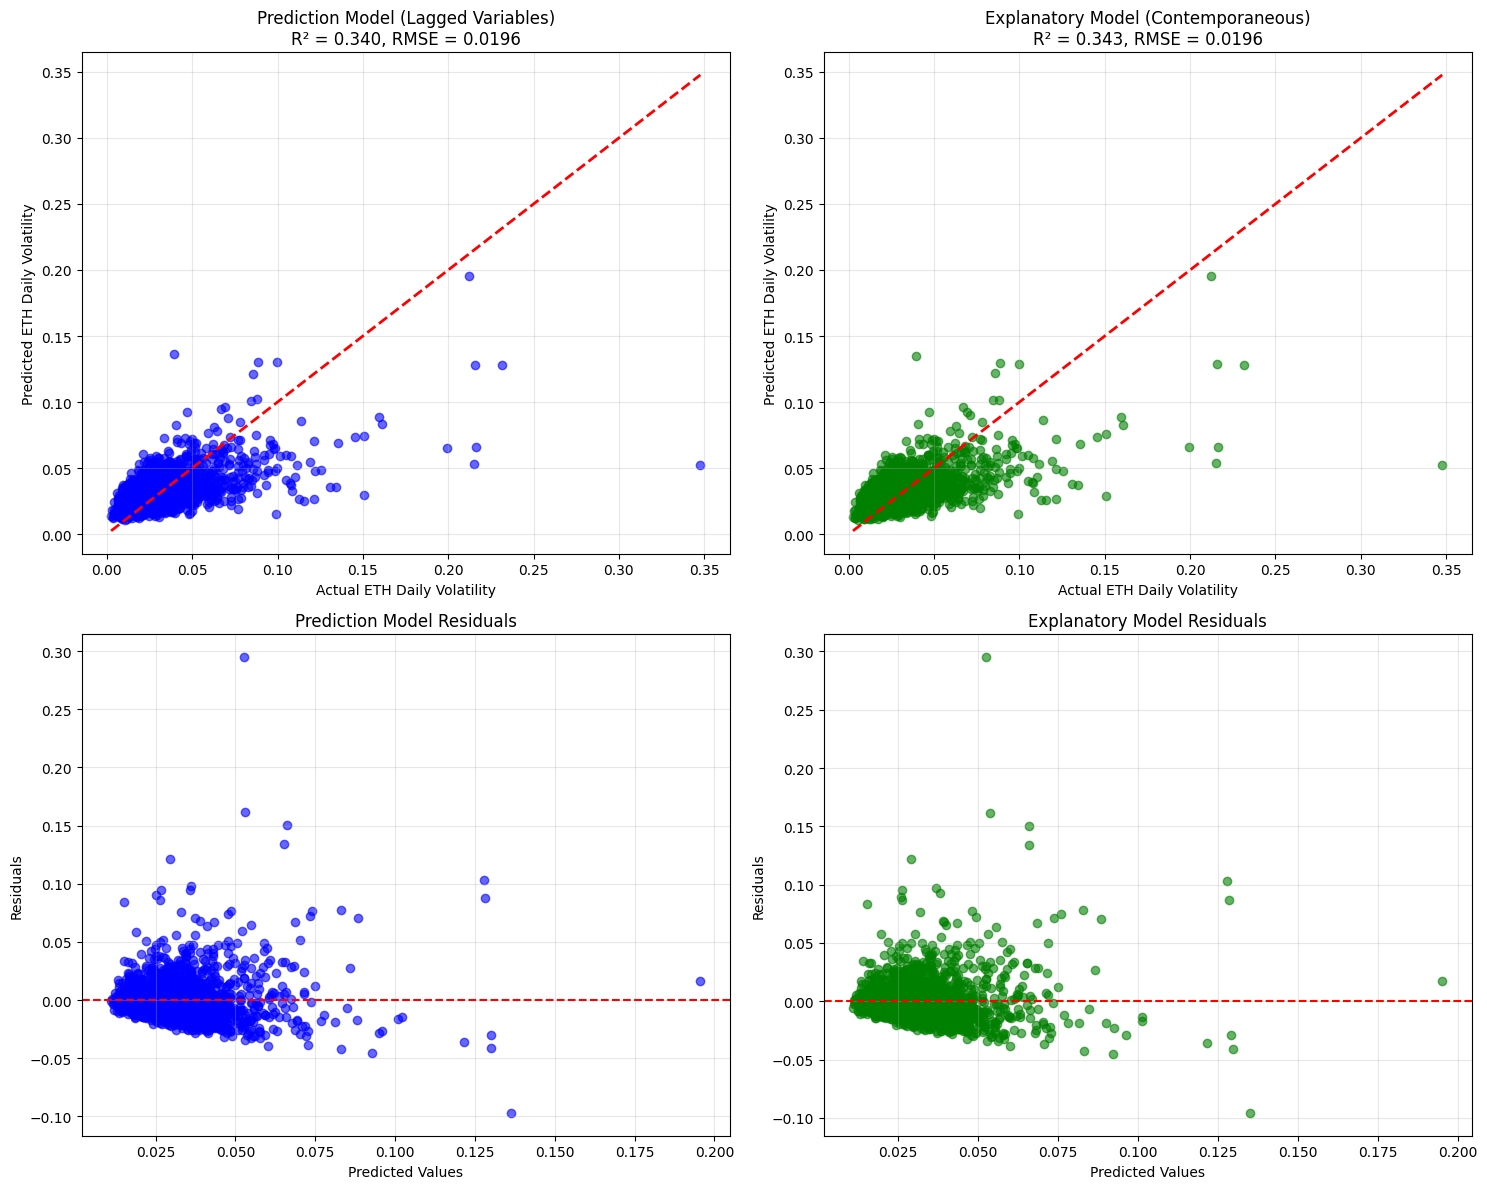


INTERPRETATION
Prediction Model: Uses only yesterday's data (R² = 0.340)
  - Tests forecasting ability with a 1-day horizon
  - Lower R² expected since we can't see today's values

Explanatory Model: Uses yesterday's volatility + today's other variables (R² = 0.343)
  - Tests what explains volatility on the same day
  - Higher R² expected since we use contemporaneous information

RMSE Comparison:
  - Prediction Model: 0.0196
  - Explanatory Model: 0.0196
  - Difference: 0.0000


In [62]:
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Calculate R-squared and RMSE for both models
pred_r2 = pred_results.rsquared
exp_r2 = exp_results.rsquared

# Get predictions from the fitted models
y_pred_hat = pred_results.fittedvalues
y_exp_hat = exp_results.fittedvalues

# Calculate RMSE
pred_rmse = np.sqrt(np.mean((y_pred - y_pred_hat)**2))
exp_rmse = np.sqrt(np.mean((y_exp - y_exp_hat)**2))

comparison_df = pd.DataFrame({
    'Model': ['Prediction Model (Lagged)', 'Explanatory Model (Contemporaneous)'],
    'R-squared': [pred_r2, exp_r2],
    'RMSE': [pred_rmse, exp_rmse],
    'N_vars': [len(available_pred_vars), len(available_exp_vars)]
})

print(comparison_df.to_string(index=False))

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Prediction Model - Actual vs Predicted
axes[0,0].scatter(y_pred, y_pred_hat, alpha=0.6, color='blue')
axes[0,0].plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual ETH Daily Volatility')
axes[0,0].set_ylabel('Predicted ETH Daily Volatility')
axes[0,0].set_title(f'Prediction Model (Lagged Variables)\nR² = {pred_r2:.3f}, RMSE = {pred_rmse:.4f}')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Explanatory Model - Actual vs Predicted
axes[0,1].scatter(y_exp, y_exp_hat, alpha=0.6, color='green')
axes[0,1].plot([y_exp.min(), y_exp.max()], [y_exp.min(), y_exp.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Actual ETH Daily Volatility')
axes[0,1].set_ylabel('Predicted ETH Daily Volatility')
axes[0,1].set_title(f'Explanatory Model (Contemporaneous)\nR² = {exp_r2:.3f}, RMSE = {exp_rmse:.4f}')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Prediction Model Residuals
pred_residuals = pred_results.resid
axes[1,0].scatter(y_pred_hat, pred_residuals, alpha=0.6, color='blue')
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_xlabel('Predicted Values')
axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title('Prediction Model Residuals')
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Explanatory Model Residuals
exp_residuals = exp_results.resid
axes[1,1].scatter(y_exp_hat, exp_residuals, alpha=0.6, color='green')
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_xlabel('Predicted Values')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Explanatory Model Residuals')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
print(f"Prediction Model: Uses only yesterday's data (R² = {pred_r2:.3f})")
print(f"  - Tests forecasting ability with a 1-day horizon")
print(f"  - Lower R² expected since we can't see today's values")
print(f"\nExplanatory Model: Uses yesterday's volatility + today's other variables (R² = {exp_r2:.3f})")
print(f"  - Tests what explains volatility on the same day")
print(f"  - Higher R² expected since we use contemporaneous information")
print(f"\nRMSE Comparison:")
print(f"  - Prediction Model: {pred_rmse:.4f}")
print(f"  - Explanatory Model: {exp_rmse:.4f}")
print(f"  - Difference: {abs(pred_rmse - exp_rmse):.4f}")

## 8. Create Lagged Variables

Create time-lagged versions of key variables for regression analysis.

In [63]:
# Export regression data for further analysis
regression_data.to_csv('../data/processed/daily_regression_data.csv', index=False)
print("Regression dataset saved as '../data/processed/daily_regression_data.csv'")

Regression dataset saved as '../data/processed/daily_regression_data.csv'


## 9. Export and Validate Final Dataset

Export the regression dataset and perform comprehensive validation checks.

In [64]:
# ============================================================================
# COMPREHENSIVE DATA VALIDATION AND STATISTICS
# ============================================================================

print("="*80)
print("FINAL REGRESSION DATASET VALIDATION")
print("="*80)

# Basic info
print(f"\nDataset Shape: {regression_data.shape[0]} rows × {regression_data.shape[1]} columns")
print(f"Date Range: {regression_data['date'].min()} to {regression_data['date'].max()}")
print(f"Time Period: {(pd.to_datetime(regression_data['date'].max()) - pd.to_datetime(regression_data['date'].min())).days} days")

# Missing values
print("\n" + "="*80)
print("MISSING VALUES CHECK")
print("="*80)
missing = regression_data.isnull().sum()
missing_pct = (missing / len(regression_data)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
missing_df = missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False)
if len(missing_df) > 0:
    print(missing_df)
else:
    print("✓ No missing values found")

# Key variable statistics
print("\n" + "="*80)
print("CENTRALITY METRICS SUMMARY")
print("="*80)
centrality_vars = ['top1_centrality', 'top3_centrality', 'top5_centrality', 'top10_centrality', 
                   'top20_mean', 'top20_std', 'hhi', 'gini']
print(regression_data[centrality_vars].describe().round(4))

print("\n" + "="*80)
print("VOLATILITY MEASURES SUMMARY")
print("="*80)
vol_vars = ['prof_garman_klass_vol', 'prof_yang_zhang_vol', 'yf_garman_klass_vol', 
            'yf_yang_zhang_vol', 'eth_intraday_vol', 'market_volatility']
available_vol_vars = [v for v in vol_vars if v in regression_data.columns]
print(regression_data[available_vol_vars].describe().round(6))

print("\n" + "="*80)
print("RETURNS AND TURNOVER SUMMARY")
print("="*80)
return_vars = ['eth_return', 'market_return', 'eth_turnover', 'market_turnover']
available_return_vars = [v for v in return_vars if v in regression_data.columns]
print(regression_data[available_return_vars].describe().round(6))

# Data quality checks
print("\n" + "="*80)
print("DATA QUALITY CHECKS")
print("="*80)

# Check for duplicates
duplicates = regression_data.duplicated(subset=['date']).sum()
print(f"Duplicate dates: {duplicates}")

# Check for extreme values (outliers)
print(f"\nExtreme volatility values (>1.0): {(regression_data['prof_garman_klass_vol'] > 1.0).sum() if 'prof_garman_klass_vol' in regression_data.columns else 'N/A'}")
print(f"Extreme returns (abs > 0.5): {(regression_data['eth_return'].abs() > 0.5).sum() if 'eth_return' in regression_data.columns else 'N/A'}")

# Check centrality ranges
print(f"\nTop1 centrality range: [{regression_data['top1_centrality'].min():.4f}, {regression_data['top1_centrality'].max():.4f}]")
print(f"HHI range: [{regression_data['hhi'].min():.4f}, {regression_data['hhi'].max():.4f}]")
print(f"Gini range: [{regression_data['gini'].min():.4f}, {regression_data['gini'].max():.4f}]")

# Correlation check (brief)
print("\n" + "="*80)
print("KEY CORRELATIONS (Centrality vs Volatility)")
print("="*80)
if 'prof_garman_klass_vol' in regression_data.columns:
    corr_vars = ['top1_centrality', 'top20_mean', 'hhi', 'gini', 'prof_garman_klass_vol']
    print(regression_data[corr_vars].corr()['prof_garman_klass_vol'].round(4))

print("\n" + "="*80)
print("✓ VALIDATION COMPLETE")
print("="*80)
print(f"\nDataset saved to: ../data/processed/daily_regression_data.csv")
print(f"Total observations: {len(regression_data):,}")
print(f"Total variables: {regression_data.shape[1]}")

FINAL REGRESSION DATASET VALIDATION

Dataset Shape: 1836 rows × 64 columns
Date Range: 2020-07-13 00:00:00 to 2025-07-22 00:00:00
Time Period: 1835 days

MISSING VALUES CHECK
✓ No missing values found

CENTRALITY METRICS SUMMARY
       top1_centrality  top3_centrality  top5_centrality  top10_centrality  \
count        1836.0000        1836.0000        1836.0000         1836.0000   
mean           31.0486          64.3351          75.0098           85.5836   
std             9.6955          14.6732          11.3286            6.2788   
min            13.3136          38.7097          49.5466           64.3229   
25%            24.0609          53.6621          65.4035           80.6836   
50%            27.6724          56.8336          69.9831           84.1595   
75%            39.8777          80.7797          88.9113           92.3552   
max            58.9464          93.3284          95.4139           96.6320   

       top20_mean  top20_std        hhi       gini  
count   1836.00